# Exploring Recommendation System Suitability By User History Depth  
## Recommendation Building and Comparison

Pippi de Bree

## Table of Contents
### [Introduction](#Introduction)
### [Library Imports](#Imports)

### [Song Data Based Recommendations](#song)

#### [A User Independent Recommendation Function](#Top) 
#### [A Content Based Recommendation System](#Content)

### [Collaborative Filtering For Recommendations](#collab)
#### [A Taste Decomposed Recommendations](#SVD)
#### [A User-Similarity Collaborative Filtering Recommendation System](#usersim)

### [Conclusion](#Conclusion)

# Introduction <a id=Introduction a>

Now we can begin to consider how differnt recommender systems will work with this data. This exploration will consider a few different options for recommendation, depending on the amount of data known about the specific user. The Taste Profile dataset has a minimum appearance of 10 times for a user, and we have reinforced this in order to limit the number of users with little data (this will be easier when considering complicated models). We will create artificial scenarios for users not having much data. There are four types of recommendation we will consider: a most popular songs recommendation, a content based where we recommend songs based on their similarity to a particular song we know the user likes. After these we will use a Singular Value Decomposition (Simon Funk's, to be specific) to get latent features which will allow us to make predictions based on putting the decomposition back together. Finally, we will look at collaborative filtering, wherein, if a user has enough data, we can use this to find similar users and use this user's ratings to recommend songs. Though we will be working in this notebook, the code to build the recommendation classes are in a file named `recommenders.py`, which we import below as a package. This file contain documentation for the specifics of each class and class function. It also contains some evaluation metric functions. 

# Library Imports <a id=Imports a> 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import ds_utils_capstone
import capstone_utils
import recommender



from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics.pairwise import cosine_similarity

from surprise import Dataset
from surprise.reader import Reader
from surprise.prediction_algorithms.matrix_factorization import SVD as FunkSVD
from surprise.model_selection import LeaveOneOut

import random

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from surprise import accuracy
from surprise.model_selection import train_test_split as train_test_splitSurprise

from surprise.model_selection import GridSearchCV as GridSearchCVSurprise
from surprise.model_selection import cross_validate

from scipy.stats import rankdata
from scipy.stats import kendalltau

import math

This notebook finally combines our taste profile (`tp`), song (`sl`), and song information (`sl_names`) datasets. Therefore, for ease of use, a read-in function can be found in the `capstone_utils` library. This function makes some changes to the song information file by giving the column titles nicer formatting (Capitalising) and removing the track column (as it is not needed in the audio-less iteration of this project). 

In [2]:
sl, sl_names, tp = capstone_utils.rec_data_readin()

Song Data Read In
DataFrame contains 4216 rows and 105 columns.
No missing values or duplicared rows found.

Song Name Information Read In
DataFrame contains 4216 rows and 4 columns.
No missing values or duplicared rows found.

Taste Profile Read In
DataFrame contains 722394 rows and 3 columns.
No missing values or duplicared rows found.


As this was as success we can begin our exploration of the recommendation systems. We will consider two main types of systems. Firstly, systems based in the content of songs and secondly systems that use collaborative filtering to draw insights from other users.

# Song Data Based Recommendations <a id=song>

The first iterations of recommendations are based in the raw data found in the taste profile and song data. Specific conclusions are drawn based on simple metrics for finding likable, or similar songs. 

## A User Independent Recommendation Function <a id=Top a>

To start, we will consider a user-independent recommendation system. These are useful in cases where there is no data about which songs a specific listener enjoy (this could be a new user joining a platform). With no data about a user there are little options but to recommend songs that are generally popular, with the hope that this maximises the chance that a user enjoys a song a further recommendations can be built from that starting point. We will use our taste profile data to get a general view of song popularity. We consider two metrics for song popularity within the `rec_top_songs` function (across the notebook mentioned functions will refer to the `recommenders` package, unless explicitly stated). Songs can either be considered as popular by total listen count (this is achieved by passing in `total_plays` to the `by` parameters) or by total number of listeners (`number_listeners`). It may be intuitive to think the more times a song is played overall is a better metric but these may be skewed by a large but very loyal fan base (who listen a song far more than average). An example is the extreme value in found in our EDA where a single user listening to a song 3532 times. In fact we will look to see which song this is now.

In [3]:
# finding the name of the most listened to song
sl_names.loc[tp[tp['count'] == max(tp['count'].values)]['song']]

,Title,Artist,Release
song_id,,,
SOBONKR12A58A7A7E0,You're The One,Dwight Yoakam,If There Was A Way


Considering we want to maximising the number of different people that enjoy the songs we recommend (to better the chance that our user enjoys it) looking at the number of listeners could give us a better spread of taste. We will look at the difference in these options and see if one is better.

In [4]:
# finding top recommendations based on total listen count (this is the function's default)
recommender.rec_top_songs(tp, sl_names)

,Title,Artist,Release
song_id,,,
SOBONKR12A58A7A7E0,You're The One,Dwight Yoakam,If There Was A Way
SOCVTLJ12A6310F0FD,Clocks,Coldplay,A Rush Of Blood To The Head
SOGPBAW12A6D4F9F22,Livin' On A Prayer,Bon Jovi,Cross Road
SONYKOW12AB01849C9,Secrets,OneRepublic,Waking Up
SOKLRPJ12A8C13C3FE,The Scientist,Coldplay,The Scientist
SOFKABN12A8AE476C6,Just Dance,Lady GaGa / Colby O'Donis,Just Dance
SOWCKVR12A8C142411,Use Somebody,Kings Of Leon,Hitzone 49
SOPXKYD12A6D4FA876,Yellow,Coldplay,Deejay 25
SOLFXKT12AB017E3E0,Fireflies,Charttraxx Karaoke,Karaoke Monthly Vol. 2 (January 2010)


Surprisingly, this exteme song listen case did skew our popularity data, as it is recommended as the top song. We could begin to consider that this may be an outlier, but it is hard to not consider this in the specific users behavior. Regardless, we will look at how much of an overlap there is between this and the recommendation selected when using number of distinct listeners as a popularity metric.

In [5]:
recommender.rec_top_songs(tp, sl_names, by='number_listeners')

,Title,Artist,Release
song_id,,,
SOCVTLJ12A6310F0FD,Clocks,Coldplay,A Rush Of Blood To The Head
SOGPBAW12A6D4F9F22,Livin' On A Prayer,Bon Jovi,Cross Road
SONYKOW12AB01849C9,Secrets,OneRepublic,Waking Up
SOPQLBY12A6310E992,Creep (Explicit),Radiohead,Pablo Honey
SOKLRPJ12A8C13C3FE,The Scientist,Coldplay,The Scientist
SOFKABN12A8AE476C6,Just Dance,Lady GaGa / Colby O'Donis,Just Dance
SOWCKVR12A8C142411,Use Somebody,Kings Of Leon,Hitzone 49
SOPXKYD12A6D4FA876,Yellow,Coldplay,Deejay 25
SOLFXKT12AB017E3E0,Fireflies,Charttraxx Karaoke,Karaoke Monthly Vol. 2 (January 2010)


There is clearly overlap an between these two metrics, though not a complete copy. This may be because songs that are listened to a lot, have high counts because of the vast number of distinct listeners. Further investigation to how users respond to songs based on these options could lead to a clearer understanding of which to use. For now, we will remain with the default total play metric. It is interesting to note, however, that instead of typical Pop songs, most of these recommendations are well known Rock songs. This is reflective of the time, the 2000s, when Rock dominated popular music much more than it does currently.

Though this is a very simple model, there is little that can be added to it without knowledge of the user. It is also hard to evaluate it's success as it cannot be known whether recommendations are similar to the user's taste. A development of this model could be adding user provided data to give clearer recommendations, for example if users entered genres they enjoyed or specific artists.

We will now continue on to recommendations based on user data. We will develop to a system designed for a deep user history, but will start with the most basic user-based recommendation, Content Based.

## A Content Based Recommendation System <a id=Content a>

Now we can begin to consider how a user who only has only one, or a few songs, that we know they enjoy. In this case we will recommend songs similar to the known songs, based on the cosine similarity. Cosine similarity is a measure of how similar two sequences of numbers are, not in magnitude but in direction. In this case the song data for specific songs in the `sl` dataset will be compared to one another using this metric. The assumption here being that the more similar songs a song is to the one the user likes, the more likely they are to enjoy it.

To create these recommendations we created a system class named `ContentRecommender`. It takes in the taste profile, and recommends the users songs based on the `number_of_songs_to_consider` parameter, by default 3 (though it can be less for a one-listen user). As mentioned above, there will be a level of artificiality in creating users with fewer listen counts (because we benefit later from having a dataset with high listen counts). This is not an issue for the integrity of the model because we are only using the taste profile to get a few songs for a specific user. The only bias is that when selecting songs from the user taste profile, the songs chosen are those the user has listened to most. This was chosen because if a system has a scale of which songs a user likes more, it is not reasaonable to not do so. (Even with 2 listen counts a system should rely more heavily on the song that was enjoyed more). 

Because we have no user information other than alphanumeric codes, the system randomises a user within the taste profile for recommendation. We will not pass in a specific user, though the class does have this functionality. 

To start using the system it must first be intialised with the data, to build the framework for recommendations (More details can be found in the documentation within the `recommenders` package).

In [6]:
# initialising the recommender class
contrec = recommender.ContentRecommender(tp, sl, sl_names)

Once this is done, we can call the class `recommend_user` function to create recommendations for a randomly selected user. This function calculates the number of recommendations needed to be calculated for each song that the user is known to like (the initialisation of the function sets this to 3, if no other number is passed in) to get 12 (the default) recommendations. It then calls the `content_rec` function, which uses the cosine similarity matrix created in the class intialisation, to get the most similar songs for each passed in user song. These recommnedations are then concatenated and reported to the user. 

In [7]:
# get recommendations for randomised user
contrec.recommend_user()

,Title,Artist,Release
song_id,,,
SOVGKPF12A8AE45594,Come On Eileen,Dexys Midnight Runners,Kids Sing Along Pac
SONESVY12A6310EA85,Geno,Dexy's Midnight Runners,Original Hits - Number 1s
SOLPGYI12AF72A5C73,Geno (John Peel Session),Dexy's Midnight Runners,John Peel Session (26th February 1980_ rec 26/...
SOTYTQU12A67FFB35D,Tengo Muchas Alas,Maná,Amar es Combatir
SOHXLWQ12A8C139B19,Walking In Memphis,Lonestar,It's All About The Music
SOHNNDV12A58A7F9D7,Princesa,Joaquin Sabina Y Viceversa,Juez Y Parte
SOPZFOA12A8C13849F,I'll Stick Around,Foo Fighters,Foo Fighters
SOUWVQF12A58A78C59,For All The Cows,Foo Fighters,Foo Fighters
SOXVVSM12A8C142224,Everlong,Foo Fighters,Greatest Hits


There is also a function within the class for getting recommendations for a specific song, `similar_song`. Perhaps this could be used if a listener has not started to use the streaming platform but does offer up a specific song that they enjoy. Similarily to `recommend_user` it is reliant on the intialisation of the class beforehand. This function can also create a randomised song to recommend, but we will show the input functionality. We will first print the information for the specific song, for comparison.

In [8]:
sl_names.loc['SOXUDXA12AB0189075']

Title       You Wanted A Hit
Artist       LCD Soundsystem
Release    This Is Happening
Name: SOXUDXA12AB0189075, dtype: object

In [9]:
# get recommendations based on input song
contrec.similar_songs('SOXUDXA12AB0189075')

,Title,Artist,Release
song_id,,,
SOCGXLO12A58A7CCFD,The Girl and The Robot,Röyksopp,The Girl and The Robot
SOAPHBN12AF72A60EF,Get Innocuous! (Soulwax Remix),LCD Soundsystem,Someone Great
SOIDIGW12A8C13BAC1,Colours (Remixed By Fred Falke),Hot Chip,Colours (The Mixes)
SODUZYO12A58A75BE1,An Honest Mistake,The Bravery,Lifestyle2 - Dance Grooves Vol 1
SOQSSLV12A8C1311CB,Primitive,Róisín Murphy,Overpowered


As can be seen from the above outputs, there is an issue that results from the form of our data. Because the song data relies heavily on artist terms to find similarity within songs, a songs by the artist is likely to be recommended. (All songs by the same artist have the same artist terms connecting them, making the vectors used to calculate cosine similarity more similar than different artists).

However, we do now have recommendations based on the specific tastes of a user. This is very useful for users just beginning to use a streaming platform or interacting with some specific recommendation system. Overall, this system works fine for it's use, but could probably be developed with more specific song data, rather than a reliance on artist terms for genre coding. At this point we are still missing the ability to evaluation our recommendations.  Because there is little sentiment involved in the users choice (other than the fact that the class choses the songs that the user has listened to most) we cannot know if the recommendations match the user's taste.

Having looked at these content based solutions, we will begin to consider the nuance in the user's taste, as well as the taste of similar users. 

# Collaborative Filtering For Recommendations <a id=collab a>

Now that we have recommendation solutions for users with no or little listening history for users, we can begin  to consider more complex recommendation models, which use predicted enjoyment to recommend songs. The two systems we will now explore are both forms of Collaborative Filtering Recommendation. These types of recommendations use the sentiments of other users, or items, to derive conclusions about how much a user will enjoy a particular song. Songs with the highest predictions are reported back to the user. As mentioned, we are now considering models with more user data, this is because Collaborative Filtering depends highly there being deep user data to draw conclusions from. To ensure that these systems have enough users, we will limit our taste profile to only include users that appear more than 80 times. This is an extreme cut, but some of the functions within the recommender classes are very computationally intensive so limiting the dataset this much will allow for reasonable evaluation times. (In hindsight this reduction could have been done earlier in our exploration).

These limitations can also create more overlap (as users appear more in general), which is good when creating recommendations collaboratively.

In [10]:
tp_high_user = capstone_utils.taste_profile_reduction(tp, 
                                                      sl.index.values, min_user_appearance=80, min_song_appearance=80)

Created Taste Profile with 36395 overall row triplets,
	 416 Unique Users,
	 1481 Unique Songs,
	 and a minimum song appearance of 80 and user appearance of 80


In [11]:
tp_no_ones = tp[tp['count'] != 1]

In [12]:
tp_no_ones

,user,song,count
0,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAUBGU12A6701C57A,2
1,5a905f000fc1ff3df7ca807d57edb608863db05d,SOCVTLJ12A6310F0FD,2
2,5a905f000fc1ff3df7ca807d57edb608863db05d,SOEPZQS12A8C1436C7,6
4,5a905f000fc1ff3df7ca807d57edb608863db05d,SOIYHAZ12A6D4F6D30,5
7,5a905f000fc1ff3df7ca807d57edb608863db05d,SOKLRPJ12A8C13C3FE,2
...,...,...,...
722388,8305c896f42308824da7d4386f4b9ee584281412,SOXQYSC12A6310E908,2
722389,8305c896f42308824da7d4386f4b9ee584281412,SOXVVSM12A8C142224,2
722390,8305c896f42308824da7d4386f4b9ee584281412,SOYGHOJ12A6701FFBA,4
722392,8305c896f42308824da7d4386f4b9ee584281412,SOZDGEW12A8C13E748,4


## A Taste Decomposed Recommendation System <a id=SVD a>

Firstly we will consider how we can Matrix Factorisation to create latent features for both our user and song behavior. By decomposing the taste profile from a matrix of all user and song combinations (known as the Utility Matrix) to two matrices we can derived latent features for each user and song. Latent features are hidden variables that we cannot interpret directly. They result from the decomposition and could be explored to find meaning (we will not go into this here). Once we have these decomposed we can a user's latent feature vector and a song's latent feature vector to calculate predicted values for each user-song combination. This will allow us to create predictions for all songs and find the top predictions for each user (which can then be recommended). We can also use these latent features in other ways, but we will come back to this. 

Now that we have an overview of how we can use matrix factorisation, we must conisder how to implement it. In reality, we do not have data for every song and user combination, this would undo the need for recommendations. Therefore we have a utility matrix (a matrix of each song and user combination rating) with missing values. A traditional matrix factorisation on cannot be performed with missing values, so we need to find another solution. Simon Funk's SVD algorithm treats the decompositon of this incomplete utility matrix as an optimisation problem. A single step of the optimisation goes as follows. A decomposition of the matrix is created based on a number of latent features to find (this needs to be established beforehand). To evaluate this decomposition, the two sub-matrices are combined using a dot product. As this gives us recomposed values for each song and user combination, these can be seen as the predictions for the user's song rating. To evaluate the accuracy of these predictions (and therefore of the decomposition) the approximation error between the predicted value and their corresponding known results are calculated using root means squared error. Once this evaluation metric is known, the aim is to minimise it (getting close as possible to perfect predictions). To do so the algorithm moves in the direction of the derivative of the approximation error for each iteration. This is repeated until a criterion is met, or the number of iterations of the algorithm is reached. 

As a note, because the algorithm is optimising known results it is also optimising unknown results because it is getting better decompositions for each specific user's and item's latent features.

In our `3_FeatureEngineering` we mentioned briefly that we need to encoding our listen counts into ratings. This is because the Surprise library, within which we will use the Funk SVD, requires that data be in the form of ratings. The scaling and rating exploration resulted in using a MinMax Scaler with a BoxCox transformation. The function that performs this scaling is called within the recommendation system `SurpriseDecompositionRecommender` and can be performed on all the data in one go or by user. Once the data is in the form of Surprise Dataset object, it can be turned into a utility matrix of ratings. At this point we can begin to use the Funk SVD algorithm. 

As this is an optimisation problem we will use surprises version of `GridSearchCV` (it is imported as `GridSearchCVSurprise` to reduce confusion). Cross validation is important in this case because we need to ensure that the decomposition performs well across the whole taste profile, not a single subsection. GridSearchCV performs cross validation by taking a grid of parameters to be looked at and fitting each combination in the model k-times, where k is the number of folds in the cross validation. Model accuracies are then reported for every fold, but means accross the folds can be accessed in order to compare different parameters. `GridSearchCVSurprise` is built on top of Pipeline functionality, so the grid passed to it is essentially a grid of estimators (as would be passed to a pipeline). In order to get our best possible decomposition we will also use root mean squared error evaluation predictions. 

A note on training and testing. The thought behind not include training and testing sets in these explorations is as follows. This GridSearch's use of cross validation ensures that we get the best possible optimisation of RMSE by checking the perfoemance of the optimisations with the validation set (5 times). Once this decomposition is built it would be hard to consider how we could add data points without re-optimising our SVD. This does seem like a lot of work computationally, as it would suggest that in a functioning system this re-optimisation would need to be performed regularly. 

The parameters for our grid search are as follows:
1) epochs (`n_epochs`) - The number of iterations the algorithm will run for (i.e how many times it will reoptimise)\
2) learning rate (`lr`) - The rate at which the algorithm learns. This can be thought as the size of the steps taken in the optimisation direction. Bigger 'steps' mean faster learning but could result in overstepping, where as smaller 'steps' are more accurate, but slower to move toward optimal.\
3) number of factors (`n_factors`) - This is the number of latent features to create. Intutively, the higher this number is the more features there are to help create an accurate prediction. However, too high a number results in overfitting to the known data (this could be an issue for unknown ratings).\
4) regularisation (`reg_all`) - This is the penalty assigned to the magnitude of the features (in essense to reduce overfitting to extremes (say one user who has only given a 5 rating). 

Before we can perform the gridsearch, we need to intialise the class. We will first use the default together scaling to get ratings from our taste profile listen counts.

In [13]:
decomprec = recommender.SurpriseDecompositionRecommender(tp_high_user, sl_names)

1.0    18971
2.0     7228
4.0     4765
3.0     3440
5.0     1991
Name: rating, dtype: int64


With the class initialised we can consider which parameters should be input into our grid. Firstly, we know that the number of factors used increases the precision of the model, but we do not want to overfit. We will try factors of size 10, 20, 30 and 40 (though expect that 40 factors will be part of our optimal version). For epochs we will try 50 and 100 (though again, suspect that the higher number will perform better). We will not go over 100, to manage computational load. The default learning rate is 0.005 for the algorithm, but we will try some larger rates, in hopes that they point to a solution more quickly. For regularisation the default is 0.02 (but we will also try some large penalisations (because we know that there may be some extreme values from our scaling). We define these parameters below and begin our search for optimal parameters.


In [14]:
# states the parameters to use in gridsearch
funk_params = {'n_factors': [10, 20, 30, 40], 'n_epochs': [50, 100], 'lr_all': [0.005, 0.01, 0.05], "reg_all": [0.02, 0.04, 0.8, 1.2]}

# find and print parameters
decomprec.funk_decompose_search(funk_params)


Best RMSE: 1.1790760512427916
Optimal Parameters:
{'n_factors': 40, 'n_epochs': 50, 'lr_all': 0.005, 'reg_all': 0.8}


Our optimal parameters are reported above. Though these are inherent to the class now (assigned to self.best_params) it is helpful for our use to explicitly look at what performed best. Surprisingly, the optimal parameters come from using less factors and less epochs. This seems to suggest that finding the optimal values was not as computationally expensive as we had expected. 


Now that we have these can call the `funk_model` function to perform the decomposition on the entire (non-cross validated) dataset (Nothing needs to be passed into this). This is left as it's own function that needs to be called so that alterations can be made before fitting the entire dataset (i.e. the gridsearch parameters could be changed). 

After fitting the SVD, this function creates dataframes of the user matrix, song matrix and predicted ratings (as a reminder these are created by performing the dot product between the mentioned matrices). Having these predicted ratings allows us to recommend the largest predicted value songs to users (disregarding songs in their taste profile). 

In [15]:
decomprec.funk_model()

Now that we have a class with the optimal parameters for our decomposed matrices, we can begin to think about what this decomposition really represents. It is helpful to look at our predicted_ratings matrix to understand what has been built inside the recommendation system. The dataframe below shows the predicated song rating for every user and song combination, based on the values created by the decomposition.

In [16]:
decomprec.predicted_ratings.head(5)

,SOABTTR12A6D4FC2EB,SOAFVWW12A58A7E1CB,SOBYDAA12A6D4F8847,SOCVTLJ12A6310F0FD,SODHVES12A6701CE6B,SOEPZQS12A8C1436C7,SOFKABN12A8AE476C6,SOGPBAW12A6D4F9F22,SOHDSHF12A8C137530,SOKLRPJ12A8C13C3FE,...,SOXUJIF12A67ADAD43,SOVCFZC12A81C2394F,SOFOLEF12A8C13ADF0,SOXHMJM12A58A7A33A,SOTMFRY12A8C13C8A2,SOAHIJF12A6D4FDB77,SOGILMU12A67ADAD85,SOIBOUB12A58A7A338,SONCCNV12A6310E997,SOGADNW12AF72A7490
1ee591a388274035a4fd8a4ae40a9589d320bb9d,0.731407,0.619316,0.845097,1.109295,1.062599,0.951472,1.164947,1.138451,0.952193,1.144589,...,0.136627,0.374198,0.219973,0.414654,0.383641,0.185545,0.162566,0.292905,0.335561,0.144743
bc475d1315d4516bc66d27d3c4522c07b082c49d,0.742127,0.628315,0.857595,1.125837,1.077686,0.965618,1.182318,1.155423,0.966170,1.161666,...,0.137206,0.378404,0.221377,0.421274,0.390804,0.187356,0.165628,0.299754,0.340798,0.144899
99a5dc9dce9baec5d0f0898878bc5ad270bf047e,0.881212,0.746190,1.018265,1.336664,1.279701,1.146465,1.403706,1.371802,1.147259,1.379192,...,0.161790,0.450058,0.263527,0.499374,0.462385,0.223005,0.195432,0.355235,0.404182,0.172901
e5b4f068ec1446a74564b4b8b8d13dcea7d27840,1.643847,1.391853,1.899584,2.493707,2.387496,2.138849,2.618802,2.559246,2.140172,2.573056,...,0.302886,0.839009,0.491151,0.931769,0.862447,0.415652,0.366188,0.661319,0.754228,0.322113
1aa4fd215aadb160965110ed8a829745cde319eb,0.873294,0.739633,1.009173,1.324853,1.268974,1.136322,1.391290,1.359639,1.136964,1.367004,...,0.166566,0.444634,0.262720,0.494868,0.458698,0.222509,0.196130,0.350004,0.401827,0.174143


This output, however, has suspiciously low ratings. There may be a chance that the dominated sing-listen counts are skewing the data to larger predictions. 

As mentioned earlier, we have little understanding of how exactly our latent features represent the song, but using outputs like the one created in `single_song_latent_feature_graph` we can begin to get a picture. It shows the size of different latent features for a specific song.

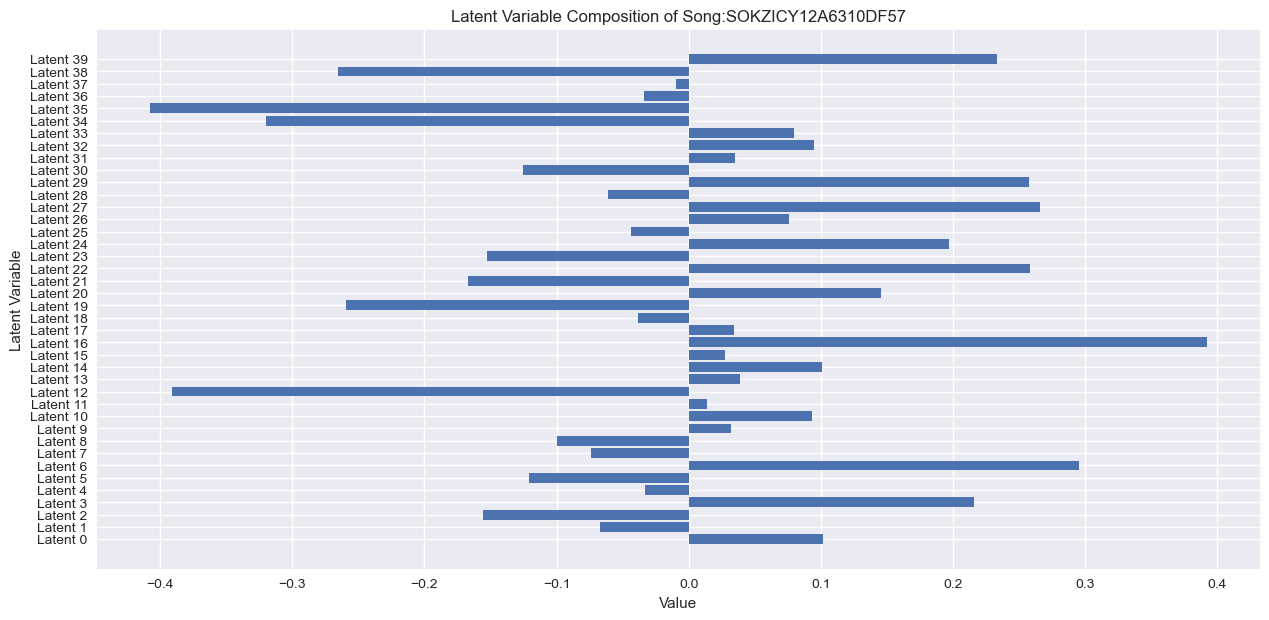

In [17]:
decomprec.single_song_latent_feature_graph()

At this point, this graph is entirely unhelpful. However, a potential development for this project could look into clustering the latent features to find specific song types that users enjoy. Since we have no information about the users we cannot make any interpretation from their latent features (we would have been able to get some sort of user profile, maybe an understanding of age and gender). However, as we have song information, and latent features that are high for specific songs, we may be able to get an understanding of what they imply. 

To recommend songs `recommend_user` finds the user row in the prediction matrix, removes known songs and returns the highest predicted songs. (As with the content based recommendations, if no user is passed in one is chosen at random). 
(More details can be found in the documentation).

There is also a function `recommend_all_users` that outputs a dataframe with recommendations for all users (we will not call this here, as it creates a very large output). 


In [18]:
decomprec.recommend_user()

,Title,Artist,Release
SOKDPMJ12A8C130578,Dice,Finley Quaye;Beth Orton,Much More Than Much Love
SOQZPBP12A6D4FD9EE,La Vida Es Limonada [Radio Mix],Marquess,¡YA!
SOULYQW12A8C13708E,People Gotta Move,Gino Vannelli,These Are The Days
SOBONKR12A58A7A7E0,You're The One,Dwight Yoakam,If There Was A Way
SODBSUF12A8C141975,Red Dirt Road,Brooks & Dunn,#1s ... and then some
SODIOLS12A67AE1411,Whistle For The Choir,The Fratellis,Costello Music
SOOMCXE12A8C140B66,The Boy Does Nothing,Alesha Dixon,Pop Princesses 2009
SOOSIWM12A670202B9,Lola Stars and Stripes (Album Version),The Stills,Logic Will Break Your Heart
SOXCCPU12A58A7BF1E,Save Room,John Legend,Mum Of The Year


We do now see to be getting more specific recommendations (beyond being stuck at a single artist). Though it is hard to see how well this recommendation has gone (beyond the success indicated by the Singular Value Decomposition).

For reason an evaluation function was created to keep track of the successes of different models throughout this exploration. It takes in the generated predictions for the taste profile. Before we pass this into the `taste_profile_evaluation` function, we need to create these predictions. `generate_taste_profile` creates a dataframe of the real listen counts, ratings and predictions.

In [19]:
decomp_preds = decomprec.generate_taste_profile_predictions()

We will keep track of the evaluation metrics for our distinct collaborative filtering models in order to consider which are the best options. 

In [20]:
evaluation_df = recommender.taste_profile_evaluation(decomp_preds, 'svd_together')

The `taste_profile_evalation` function takes in a taste profile with count, rating and rating predictions and well as a string name for the model. It then calculates the Root Mean Squared Error (this is not neccesary for this SVD recommendation system but the functionality will allow us to these with a user-similarity collaborative filtering model. Note: the RMSE from the SVD decomposition does not match the output here because we are using slightly different data forms (the full taste profile was trained on the optimal parameters to create the predictions, whereas in the gridsearch the cross-folds means that different specific data sections were used).

It also attempts to account the ordering of user listen counts (as a measure of enjoyment) within the ratings. Theorectically, if a user listen to songs more times than a different song, our decomposition should give a higher prediction to the more-listened song. For this reason we implemented kendall's tau after ranking the listen counts for each user and the predicted ratings for each user. These should be comparable rankings (we hope that more listened to songs for each user have higher rankings). The idea in using this metric is to make the differences in models more comparable. There will be specific biases in each of our models, but the hope is that, even if the actual predictions are harder to compare, the order in which they are valued can be. If we were only considering a SVD we could use Surprise's built in concordant pairs scoring metric. However, we hope to compare more models so have come up with a solution that uses Kendall's Tau to compare the ordinal rankings of the passed in listen counts and the predicted values. Kendall's Tau is correlation measure expressing what proportion of the pairs in the dataset are concordant or disconcordant. It's output ranges from 1 to -1, as the value is calculated as follows:

Kendall's Tau = (number of concordant pairs - number of disconcordant pairs) / total number of pairs 

In our use, we hope to maximise this correlation metric, as this will express that the ratings created are representative of the magnitude of listen counts (again we are basing a lot of value in the assumption that a higher listen count means a user enjoys a song more).

In [21]:
evaluation_df

,rec_model,rmse,mae,kendalltau
0,svd_together,1.450182,1.000407,0.178286


Our first model evaluation is hard to interpret without context, though it does not suggest an overwhelmingly successful build. The Kendall's Tau score is fairly low and the RMSE is high given that the ratings only go from 1 to 5.

### Individual Scaling 

In our exploration we considered that it may be a good idea to rate each user's listen counts individually. This could account for differences in user behavior, while allowing us to use other users' sentiments to draw conclusions about song likability.

We do this by passing `user_based` into our class initialisation, so that the call to the `scaling_mmb` function performs the scaling by user. We will initiate our class with this definition in hopes that we can compare how differently our model performs with the new scaling. 

In [22]:
# intialise class with userbased scaling
decomprec_user = recommender.SurpriseDecompositionRecommender(tp_high_user, sl_names, scale_by='userbased')

# perform gridsearch using same parameters
decomprec_user.funk_decompose_search(funk_params)

# create predictions based on optimal model
decomprec_user.funk_model()

# find predictions for 
decomp_preds_user = decomprec_user.generate_taste_profile_predictions()

1.0    18971
2.0     7621
4.0     3617
3.0     3253
5.0     2933
Name: rating, dtype: int64
Best RMSE: 1.258861413708732
Optimal Parameters:
{'n_factors': 40, 'n_epochs': 50, 'lr_all': 0.005, 'reg_all': 0.8}


In [23]:
# add user-based decomposition to evaluation dataframe
evaluation_df = recommender.taste_profile_evaluation(decomp_preds_user, 'svd_userbased', df=evaluation_df)

In [24]:
evaluation_df

,rec_model,rmse,mae,kendalltau
0,svd_together,1.450182,1.000407,0.178286
1,svd_userbased,1.520749,1.008615,0.186828


From this output we can see that there is little difference in scaling or not. It seems that there is a large skew towards small ratings (as we saw with the predicted ratings matrix). If we now look at ignoring these single count variables, we could assume that this would have a high impact on general predicted ratings. 

In [25]:
tp_high_user_mult = tp_high_user[tp_high_user['count'] > 1]

This block of code creates predictions for multiple listen count songs, using all in one scaling. 

In [26]:
decomprec_mult = recommender.SurpriseDecompositionRecommender(tp_high_user_mult, sl_names)
decomprec_mult.funk_decompose_search(funk_params)
decomprec_mult.funk_model()
decomprec_mult_preds = decomprec_mult.generate_taste_profile_predictions()
evaluation_df = recommender.taste_profile_evaluation(decomprec_mult_preds, 'svd_together_multonly', df=evaluation_df)
evaluation_df

2.0    7228
4.0    4765
3.0    3440
5.0    1991
Name: rating, dtype: int64
Best RMSE: 1.000025441254766
Optimal Parameters:
{'n_factors': 40, 'n_epochs': 50, 'lr_all': 0.005, 'reg_all': 0.8}


,rec_model,rmse,mae,kendalltau
0,svd_together,1.450182,1.000407,0.178286
1,svd_userbased,1.520749,1.008615,0.186828
2,svd_together_multonly,1.236163,0.968486,0.216754


We can see an improvement here overall, as RMSE has gone done and our kendall's tau has increased slightly. Intuitively, it makes sense that removing so many eqaully ranked values (the 1 rated) would improve a rank-based metric. Therefore we should be careful concluding that this model performs better for the non-single listen data.

In [27]:
decomprec_mult_user = recommender.SurpriseDecompositionRecommender(tp_high_user_mult, sl_names, scale_by='userbased')
decomprec_mult_user.funk_decompose_search(funk_params)
decomprec_mult_user.funk_model()
decomprec_mult_user_preds = decomprec_mult_user.generate_taste_profile_predictions()
evaluation_df = recommender.taste_profile_evaluation(decomprec_mult_user_preds, 'svd_usedbased_multonly', df=evaluation_df)
evaluation_df

2.0    7621
4.0    3617
3.0    3253
5.0    2933
Name: rating, dtype: int64
Best RMSE: 1.1382681003408586
Optimal Parameters:
{'n_factors': 40, 'n_epochs': 50, 'lr_all': 0.005, 'reg_all': 1.2}


,rec_model,rmse,mae,kendalltau
0,svd_together,1.450182,1.000407,0.178286
1,svd_userbased,1.520749,1.008615,0.186828
2,svd_together_multonly,1.236163,0.968486,0.216754
3,svd_usedbased_multonly,1.628163,1.243175,0.234278


This output shows the models all perform well in different ways. It seems that as we mangage to slightly boost our kendall's tau value, we increase our RMSE. There is a slight contradiction in this thinking, as it seems that our SVD performing less well (ie having a higher RMSE, meaning a worse optimisation) gives better concordance. 

It seems at this point that we are ready to compare these outputs to a different type of collaborative filtering. 

## A User-Similarity Collaborative Filtering Recommendation System <a id=usersim a>

In our Matrix Factorisation based recommendation, the similarity between users was used implicitly to predict ratings. 

The differences in users was used in the decomposition to create optimal latent features for re-predicting known ratings. Now we will consider explicitly using the similiarity between users to recommend songs, put simply we will look at how similarly users have rated songs and use this similarity to give weights to other users opinions. 

In order to do this we will combine the idea of the utility matrix, from our decomposition, with the cosine similarity used in our content based recommendations. 

Though a rating system is not necessary for the structure of this recommendation system, it works as a normalisation
that allows different users to be compared (where differences in listen counts could create skews). Therefore, we will again consider the difference between scaling together and by user. After we have scaled the data we will create a utility matrix to let us easily compare the ratings of users. (More details of this can be found in the documentation but it is basically an iteration over the taste profile). With this matrix in form we can begin to think about comparing the horizontal ratings vectors in the utility matrix. There will be a lot of sparse data in this (as most listeners have not listened to most songs). 

This user-similarity based method relies on an overlap of songs listened to by other users, so we will only look at users who have at least 5 songs in common. We can then find the cosine similarity between the vectors of rated predictions for the same songs. As we will try to find a number of similar users, the cosine similarity between the current (being recommended) user and other users will be used as weights in creating predictions. This is done withint the `similar_users_to_user` class function. This function iterates over every other user in the dataset, and finds those with large enough overlaps and then reports the cosine similarity in a Series (with the index being the other users' ids and the values being the similarities). 

The `user_rating_prediction` class function uses this output to create a prediction for a specific song by iterating over the similar users to find those who have recommended a specific song. If they have rating (listened to) the song their rating is multiplied by the cosine similiarity (acting as a weight) and then added to a running total, which is in the end divided by the number users whose ratings were considered. This number is the predicted rating for the song.

To get a range of predicted ratings, the `recommend_user` function uses the `similar_users_to_user` function to get similar users. Then all of the songs that these users have listened to (except the ones the current user has) are looped over and if more than the needed_similar_rating threshold is met, the song is given a predicted rating. 

This is computationally intensive. Especially when we begin to generate predictions to compare known ratings with predictions.

In [28]:
collab = recommender.CollaborativeSongRecommender(tp_high_user, sl_names)

1.0    18971
2.0     7228
4.0     4765
3.0     3440
5.0     1991
Name: rating, dtype: int64

Starting Utility Matrix Formation
Created Utility Matrix with:
	 416 Unique Users
	1481 Unique Songs


The initialisation scales the data and the creates the utility matrix, from here we call the mentioned functions to make our predictions and find similar users.

For ease of understanding, we will show a `similar_users_to_user` output.

In [29]:
collab.similar_users_to_user()

(bc475d1315d4516bc66d27d3c4522c07b082c49d    [[0.9791300486523296]]
 e5b4f068ec1446a74564b4b8b8d13dcea7d27840    [[0.9664751735958172]]
 1aa4fd215aadb160965110ed8a829745cde319eb    [[0.9515025711248198]]
 34e191b5e3ac4d0b86b100e3325aa46c34998248     [[0.808290376865476]]
 edc19f85936d55d76b673d008bd2d220707af47a     [[0.681105957574728]]
                                                      ...          
 e6e0f68e948d7bcbf2ed9c4506a40a139a5e7bc7    [[0.5351295510095068]]
 f056c835a57ea307b4ed56bf4dfa99290ab7924c    [[0.8501902901184915]]
 6f7758ee2ca227c0a41ba4799c220ab0bad353b7       [[0.9320546490018]]
 d964fc033291078031d117ed10adfb615948256d    [[0.7559289460184544]]
 739ee4c555b0558cbf2c75abc0782f3f10941c35    [[0.9460998335825322]]
 Length: 305, dtype: object,
 Series([], dtype: float64))

This series shows the cosine similarity between the current user (randomised in the call) and each user in the index. We will also demonstrate the `user_rating_prediction`, with a random user and random song. 

In [30]:
collab.user_rating_prediction()

(1.7404066709130164, nan)

There is a nan output here - we will get to this momentarily.

Though we have limited our overlap as much as possible, we still have cases where this randomisation does not produce an output. This is an example of how user-data reliant this system is. We can still produce recommendations, but must consider that the songs recommended are highly reliant on there being an overlap. It is unlikely that we will produce no recommendations but this is possible with very little user data. There are cases where randomising the user gives no recommendations but this case is hard coded to show an output.

In [31]:
collab.recommend_user('382a01bfd76a834d1bc309ccb9f6ee1be218def7')

382a01bfd76a834d1bc309ccb9f6ee1be218def7


,Title,Artist,Release
song_id,,,
SOKDPMJ12A8C130578,Dice,Finley Quaye;Beth Orton,Much More Than Much Love
SOOMCXE12A8C140B66,The Boy Does Nothing,Alesha Dixon,Pop Princesses 2009
SOPXETB12AF72A59FF,Anthem Part Two,Blink-182,Take Off Your Pants And Jacket
SOCOZKO12B0B8066E3,Sweetest Goodbye,Maroon 5,Songs About Jane
SOMJYYH12A67020C64,Picture Of You,Boyzone,I Am Happy
SOQZPBP12A6D4FD9EE,La Vida Es Limonada [Radio Mix],Marquess,¡YA!
SODBSUF12A8C141975,Red Dirt Road,Brooks & Dunn,#1s ... and then some
SOPGYEP12A6D4FBFEF,La Bayamesa,Buena Vista Social Club,Buena Vista Social Club
SOAXJIC12A6D4FBFD7,Amor de Loca Juventud,Buena Vista Social Club,Buena Vista Social Club


Now, that we have a system of recommending songs based on cosine similiarity, we consider the the latent features of our SVD as measures of similarity between users. To bring this data into our `CollaborativeSongRecommender`, we will pass the user_matrix_df created by our together-rated `decomprec_mult` instance of `SurpriseDecompositionRecommender` into our intialisation. This will allow us to compare the similarities implicit to the SVD to our explicit ratings. Note we will only be using the multiple data at this point because this model is computationally very intensive and we should not gain as much value from 1 ratings, as high ratings. We are hoping to find similar users with high ratings to give us positive predicted ratings and good recommendations, users not enjoying songs is less useful here (though a measure of similarity in disliking something should not be undervalued.

In [32]:
collablatenttogether = recommender.CollaborativeSongRecommender(tp_high_user_mult, sl_names, user_matrix_df=decomprec_mult.user_matrix_df)

2.0    7228
4.0    4765
3.0    3440
5.0    1991
Name: rating, dtype: int64

Starting Utility Matrix Formation
Created Utility Matrix with:
	 416 Unique Users
	1430 Unique Songs


In [33]:
collablatenttogether.user_matrix_df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
1ee591a388274035a4fd8a4ae40a9589d320bb9d,-0.149713,-0.036936,-0.659146,0.283276,-0.102569,-0.311896,-0.102204,0.026433,0.065574,-0.289608,...,0.051425,0.699545,0.223167,-0.234208,-0.124986,-0.080936,-0.041724,-0.027719,0.071014,0.254559
bc475d1315d4516bc66d27d3c4522c07b082c49d,-0.086280,-0.023389,-0.539629,0.209928,-0.087403,-0.238844,-0.075258,0.036664,0.083878,-0.186409,...,0.031256,0.565524,0.202478,-0.149586,-0.092397,-0.091790,-0.019899,-0.013759,0.054159,0.217527
99a5dc9dce9baec5d0f0898878bc5ad270bf047e,-0.097760,-0.007439,-0.549111,0.210850,-0.080952,-0.226103,-0.063284,0.015937,0.090955,-0.201668,...,0.034972,0.557214,0.213273,-0.161280,-0.096608,-0.105914,-0.031306,-0.019352,0.063662,0.211065
e5b4f068ec1446a74564b4b8b8d13dcea7d27840,-0.121924,-0.027012,-0.719933,0.287372,-0.119980,-0.319228,-0.093030,0.047490,0.132439,-0.255875,...,0.040153,0.760238,0.286392,-0.218486,-0.127109,-0.129512,-0.018134,-0.018943,0.083729,0.295522
1aa4fd215aadb160965110ed8a829745cde319eb,-0.116214,0.002295,-0.621944,0.247086,-0.119823,-0.268656,-0.071009,0.041808,0.114480,-0.203000,...,0.018792,0.651918,0.230245,-0.195812,-0.113216,-0.115184,-0.012054,-0.008283,0.066183,0.244183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
e6e0f68e948d7bcbf2ed9c4506a40a139a5e7bc7,-0.122625,-0.027624,-0.710855,0.287612,-0.111975,-0.317625,-0.085279,0.049559,0.138874,-0.258397,...,0.043260,0.747388,0.281561,-0.214706,-0.123568,-0.123310,-0.021222,-0.022851,0.070481,0.295440
f056c835a57ea307b4ed56bf4dfa99290ab7924c,-0.118435,0.000376,-0.655830,0.259163,-0.097420,-0.284218,-0.069440,0.025546,0.100317,-0.252532,...,0.039457,0.693923,0.266603,-0.180227,-0.123718,-0.128778,-0.017563,-0.022357,0.081457,0.254893
6f7758ee2ca227c0a41ba4799c220ab0bad353b7,-0.105212,-0.034319,-0.651572,0.257903,-0.095595,-0.272444,-0.084163,0.042743,0.108851,-0.224884,...,0.023962,0.665911,0.246820,-0.183138,-0.116072,-0.111024,-0.017981,-0.011195,0.069123,0.257023
d964fc033291078031d117ed10adfb615948256d,-0.122033,0.003038,-0.584555,0.202528,-0.099827,-0.265544,-0.053366,-0.015168,0.069741,-0.201225,...,0.034896,0.627882,0.245271,-0.169100,-0.119790,-0.126194,-0.004127,0.008820,0.084133,0.264015


We now have access to the latent features of each our users and could use these to recommend songs.

In [34]:
collablatenttogether.user_rating_prediction()

(2.570515108052433, 2.6964983325565597)

We now have two different predictions, one based on cosine similarity between ratings and one based on cosine similiarity between latent features. (As a note the cosine similarities for latent features are still only calculated if there is a large enough overlap - a further step could be using latent feature similiarity beyond these bounds). 

We can now also give recommendations based on latent feature cosine similarity, by passing in `latent` to the `similarity_type` parameter of the `recommend_user` function. Let's look at the difference in output when using these different metrics. 

In [35]:
collablatenttogether.recommend_user(rec_user='382a01bfd76a834d1bc309ccb9f6ee1be218def7', similarity_type='latent')

382a01bfd76a834d1bc309ccb9f6ee1be218def7


,Title,Artist,Release
song_id,,,
SOKDPMJ12A8C130578,Dice,Finley Quaye;Beth Orton,Much More Than Much Love
SOIIUPO12A6D4F7EA8,A Teenager In Love,Dion & The Belmonts,The Best Of Dion & The Belmonts
SOPGYEP12A6D4FBFEF,La Bayamesa,Buena Vista Social Club,Buena Vista Social Club
SOWGPQK12A6701F299,Can't Help Falling In Love (Album Version) (St...,Michael Bublé,Come Fly With Me
SONMCDN12A8C141750,Groove Me,King Floyd,Super Non-Stop Soul Dance
SOQZPBP12A6D4FD9EE,La Vida Es Limonada [Radio Mix],Marquess,¡YA!
SOHDSHF12A8C137530,Sitting,Cat Stevens,On The Road To Find Out (Repackaged)
SOHVDZM12A8C13AE07,Over The Hills And Far Away,Nightwish,Over the Hills and Far Away
SOXIUMU12A6701D946,Hey Mama,Black Eyed Peas,Hey Mama


In [36]:
collablatenttogether.recommend_user(rec_user='382a01bfd76a834d1bc309ccb9f6ee1be218def7')

382a01bfd76a834d1bc309ccb9f6ee1be218def7


,Title,Artist,Release
song_id,,,
SOIIUPO12A6D4F7EA8,A Teenager In Love,Dion & The Belmonts,The Best Of Dion & The Belmonts
SOHDSHF12A8C137530,Sitting,Cat Stevens,On The Road To Find Out (Repackaged)
SOKDPMJ12A8C130578,Dice,Finley Quaye;Beth Orton,Much More Than Much Love
SOPGYEP12A6D4FBFEF,La Bayamesa,Buena Vista Social Club,Buena Vista Social Club
SONMCDN12A8C141750,Groove Me,King Floyd,Super Non-Stop Soul Dance
SOWGPQK12A6701F299,Can't Help Falling In Love (Album Version) (St...,Michael Bublé,Come Fly With Me
SOQZPBP12A6D4FD9EE,La Vida Es Limonada [Radio Mix],Marquess,¡YA!
SOKZICY12A6310DF57,Always,Blink-182,blink-182 (explicit version)
SOXIUMU12A6701D946,Hey Mama,Black Eyed Peas,Hey Mama


We can see that there is a slight difference in the songs recommended - this may be because of the difference in each compared user's weighting (based on their similarity).

Now we look into evaluate the success of these prediction methods by generating the predicted taste profile. It should be noted that this is computationally very intense and not all values can be predicted as there are cases where this is not enough overlap between users. (This reflects the depth of data necessary for this analysis. 

In [39]:
collablatenttogether_preds = collablatenttogether.generate_taste_profile_predictions()

Unable to predict ratings for: 522 songs


From the output we can see that there was not enough overlap for the system to generate predictions for a third of the songs in this subset of the dataset. This is potentially the result of making the subset too small (and may also come from removing the single count songs. It should be noted that this creates a problem in comparing the success of the SVD algorithm and user-similarity based collaborative filtering.

Regardless, we will look into how well the latent similarity and overlap similarity metrics compared. 

In [40]:
# first we need to remove the 
collablatenttogetherpreds = collablatenttogether_preds[collablatenttogether_preds['overlap_prediction'] != 0.0]

In [48]:
evaluation_df = recommender.taste_profile_evaluation(collablatenttogether_preds, rec_model='collabmult_latent', prediction_column='latent_predictions', df=evaluation_df)


In [49]:
evaluation_df = recommender.taste_profile_evaluation(collablatenttogether_preds, rec_model='collabmult_sim', prediction_column='overlap_prediction', df=evaluation_df)


In [50]:
evaluation_df

,rec_model,rmse,mae,kendalltau
0,collabmult_latent,1.228325,1.026388,0.064978
1,collabmult_sim,1.222087,1.008397,0.083352


Now we serious a serious drop in our kendall's Tau score. This is potentially because the amount of predictions that could be made was lower and therefore removing some of them created an issue in size of sets. There is however, a lower overall RMSE than the average of the SVD's outputs. 

Now how about using a user-based scaling will perform in this same case. We will now use the user_matrix from the decomposition of multiple-listen songs with userbased scaling (`decomp_mult_user`)

In [44]:
collablatentuserbased = recommender.CollaborativeSongRecommender(tp_high_user_mult, sl_names, 
                                                                user_matrix_df=decomprec_mult_user.user_matrix_df)

2.0    7228
4.0    4765
3.0    3440
5.0    1991
Name: rating, dtype: int64

Starting Utility Matrix Formation
Created Utility Matrix with:
	 416 Unique Users
	1430 Unique Songs


In [45]:
collablatentuserbased.recommend_user(rec_user='382a01bfd76a834d1bc309ccb9f6ee1be218def7', similarity_type='latent')

382a01bfd76a834d1bc309ccb9f6ee1be218def7


,Title,Artist,Release
song_id,,,
SOKDPMJ12A8C130578,Dice,Finley Quaye;Beth Orton,Much More Than Much Love
SOIIUPO12A6D4F7EA8,A Teenager In Love,Dion & The Belmonts,The Best Of Dion & The Belmonts
SOWGPQK12A6701F299,Can't Help Falling In Love (Album Version) (St...,Michael Bublé,Come Fly With Me
SOPGYEP12A6D4FBFEF,La Bayamesa,Buena Vista Social Club,Buena Vista Social Club
SONMCDN12A8C141750,Groove Me,King Floyd,Super Non-Stop Soul Dance
SOQZPBP12A6D4FD9EE,La Vida Es Limonada [Radio Mix],Marquess,¡YA!
SOHDSHF12A8C137530,Sitting,Cat Stevens,On The Road To Find Out (Repackaged)
SOHVDZM12A8C13AE07,Over The Hills And Far Away,Nightwish,Over the Hills and Far Away
SOXIUMU12A6701D946,Hey Mama,Black Eyed Peas,Hey Mama


In [46]:
collablatentuserbased.recommend_user(rec_user='382a01bfd76a834d1bc309ccb9f6ee1be218def7')

382a01bfd76a834d1bc309ccb9f6ee1be218def7


,Title,Artist,Release
song_id,,,
SOIIUPO12A6D4F7EA8,A Teenager In Love,Dion & The Belmonts,The Best Of Dion & The Belmonts
SOHDSHF12A8C137530,Sitting,Cat Stevens,On The Road To Find Out (Repackaged)
SOKDPMJ12A8C130578,Dice,Finley Quaye;Beth Orton,Much More Than Much Love
SOPGYEP12A6D4FBFEF,La Bayamesa,Buena Vista Social Club,Buena Vista Social Club
SONMCDN12A8C141750,Groove Me,King Floyd,Super Non-Stop Soul Dance
SOWGPQK12A6701F299,Can't Help Falling In Love (Album Version) (St...,Michael Bublé,Come Fly With Me
SOQZPBP12A6D4FD9EE,La Vida Es Limonada [Radio Mix],Marquess,¡YA!
SOKZICY12A6310DF57,Always,Blink-182,blink-182 (explicit version)
SOXIUMU12A6701D946,Hey Mama,Black Eyed Peas,Hey Mama


Again, we see that these similarity metrics, latent and overlap, provide similar recommendations to our user. Unfortunately, there was little time to evaluate the success of the user-based user-similarity matrices beyond this intial recommendation output. (Generating the predicted taste profile was took too much time). 

## Collaborative Filtering Summary 

In [40]:
evaluation_df

,rec_model,rmse,mae,kendalltau
0,svd_together,1.450182,1.000407,0.178286
1,svd_userbased,1.520749,1.008615,0.186828
2,svd_together_multonly,1.236163,0.968486,0.216754
3,svd_usedbased_multonly,1.628163,1.243175,0.234278


From this output we can see the story of our different evaluations, however it is hard to realistically compare them because of the dissimiliarities in the data. Overall, the SVD performs better than the user-similaririty filterings when considering Kendall's Tau as the evaluation metric. Though it tends to have slightly worse RMSE values. The differences these evaluation metrics imply beg the question of what is more important in a recommendation system. Accuracy of predictions, or order rank. If recommendations are provided purely on the magnitude of their prediction then it has to be considered that rank is more important. (Though these two are obviously linked). If all the values are slightly off, but in the correct order the user will get the most appropriate recommendations. 

Surprisingly, the user-similarity collaborative filtering did not perform as well as expected. In hindsight, this is probably the result of there not being a large enough overlap between songs (we see this in the large proportion of un-predictable values). My expectation is that if there was more overlapping data this system would perform better than the SVD because it would have more song specific data, and could create a better picture.

# Conclusion <a id=Conclusion a>

This exploration of Recommendation Systems has considered content-based and popularity based recommendations. However, the majority of the value comes in the development of two recommendation systems the `CollaborativeSongRecommender` and the `SurpriseDecompositionRecommender`. These collaborative filtering based systems transform the data into workable formats by tranforming and scaling them (either individually or all together) to create ratings. These ratings are then used to create predictions for specific song-user combinations. These predictiongs are evaluated using Root Mean Squared Error and Kendall's Tau (both metrics considering different issues in the predictions - accuracy and ordinality). Overall, the SVD recommendations perform better on the subset of our data than the user-similarity collaborative filtering. 

## Possible Further Steps

In the Feature Engineering scaling discussion, it was mentioned that creating equal sized data for each rating may be unecessary because we want the taste profile to be reflected in how many ratings there. (We do not expect an equal amount of 5 ratings to 3 ratings). However, a further step could be adding downsampling to our recommendation systems and seeing how the data performs. Another idea would be looking at how non-rated (only scaled) data would perform within the `CollaborativeSongRecommender`. 

There is also the possibility creating user or song clusters based on the latent features created by our optimised SVD. 